In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
# import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier

In [23]:
# import datasets
air_df = pd.read_csv('air.csv')
water_df = pd.read_csv('purewater_boli_200.csv')
sugar_df = pd.read_csv('10psugarwater_boli_200.csv')
salt_df = pd.read_csv('10psaltywater_boli_200.csv')
milk_df = pd.read_csv('20psugarwater_boli_200.csv')

In [24]:
# insert labels
air_df['label'] = 0
water_df['label'] = 1
sugar_df['label'] = 2
salt_df['label'] = 3
milk_df['label'] = 4

In [25]:
# print(milk_df)

In [26]:
def phaseDenoise(df):
    csi_temp = df['CSI_DATA'].to_numpy()
    csi = copy.deepcopy(csi_temp)
    
    for i in range(len(csi)):
        csi[i] = csi[i][1:-2]
        csi[i] = csi[i].split(" ")
        csi[i] = [int(x) for x in csi[i]]
        
    m, n = len(csi), len(csi[0])
    raw_phase = [[0] * (n // 2) for _ in range(m)]
    delete_idx = []
    
    for i in range(m):
        for j in range(0, n, 2):
            if i == 0:
                if csi[i][j + 1] == 0 and csi[i][j] == 0:
                    delete_idx.append(j // 2)
    #         print([csi[i][j + 1], csi[i][j]])
            if csi[i][j] != 0:
                raw_phase[i][j // 2] = math.atan(csi[i][j + 1] / csi[i][j])
    # print(raw_phase)
    
    raw_phase = np.delete(raw_phase, delete_idx, 1)
    line = np.linspace(-27, 27, num=55)
    line = np.delete(line, 27)
    phase_m, phase_n = len(raw_phase), len(raw_phase[0])
    avg = [0 for _ in range(phase_m)]
    for i in range(len(avg)):
        avg[i] = sum(raw_phase[i]) / 54
    denoise_phase = [[0] * phase_n for _ in range(phase_m)]

    for i in range(phase_m):
        for j in range(phase_n):
            denoise_phase[i][j] = raw_phase[i][j] - ((raw_phase[i][-1] - raw_phase[i][0]) / (line[-1] - line[1])) * line[j] - avg[i]
    plt.plot(raw_phase[:, 33])
    plt.plot([row[33] for row in denoise_phase], 'r+')
    plt.show()
    print("Processing Finished")
    return raw_phase, denoise_phase

In [27]:
def liquidIdentify(base_phase, tar_phase, base_rss, tar_rss, zeta=0):
    dp = tar_phase - base_phase
    dr = tar_rss - base_rss
    omega = (np.log(10 ** (dr / 20))) / (dp + 2 * zeta * math.pi)
    return omega

In [28]:
def reduceOutliner(denoise_phase):
    std_array=np.std(denoise_phase,axis=0);
    phase_mean=denoise_phase.mean(axis=0);
    shape_num=denoise_phase.shape;
    row_num=shape_num[0];
    for i in range(54):
        for j in range(row_num):
            if((denoise_phase[j][i]>(phase_mean[i]+std_array[i]))or(denoise_phase[j][i]<(phase_mean[i]-std_array[i]))):
                denoise_phase[j][i]=phase_mean[i];

    return denoise_phase;


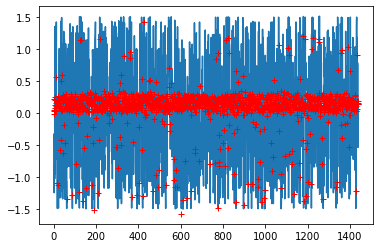

Processing Finished


In [29]:
air_raw_phase, air_denoise_phase = phaseDenoise(air_df)
air_denoise_phase_smth=np.array(air_denoise_phase);
air_denoise_phase=reduceOutliner(air_denoise_phase_smth);
air_rss = air_df['rssi'].to_numpy()
air_label = air_df['label'].to_numpy()

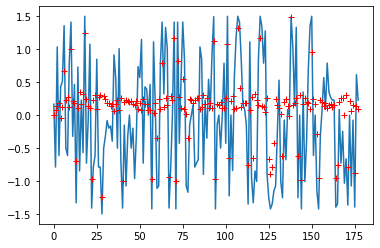

Processing Finished


In [30]:
water_raw_phase, water_denoise_phase = phaseDenoise(water_df)
water_denoise_phase_smth=np.array(water_denoise_phase);
water_denoise_phase=reduceOutliner(water_denoise_phase_smth);
water_rss = water_df['rssi'].to_numpy()
water_label = water_df['label'].to_numpy()

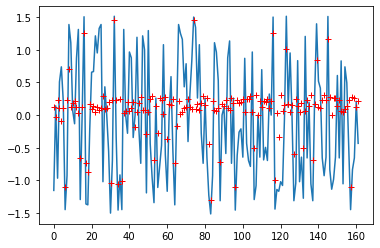

Processing Finished


In [31]:
sugar_raw_phase, sugar_denoise_phase = phaseDenoise(sugar_df)
sugar_denoise_phase_smth=np.array(sugar_denoise_phase);
sugar_denoise_phase=reduceOutliner(sugar_denoise_phase_smth);
sugar_rss = sugar_df['rssi'].to_numpy()
sugar_label = sugar_df['label'].to_numpy()

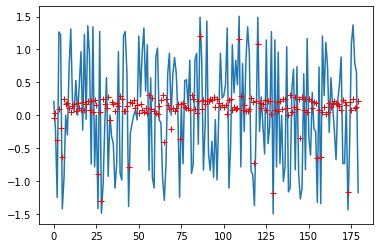

Processing Finished


In [32]:
salt_raw_phase, salt_denoise_phase = phaseDenoise(salt_df)
salt_denoise_phase_smth=np.array(salt_denoise_phase);
salt_denoise_phase=reduceOutliner(salt_denoise_phase_smth);
salt_rss = salt_df['rssi'].to_numpy()
salt_label = salt_df['label'].to_numpy()

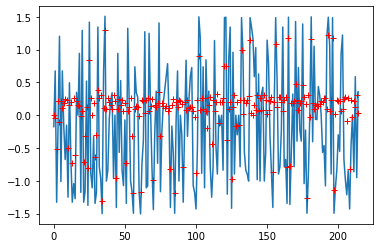

Processing Finished


In [33]:
milk_raw_phase, milk_denoise_phase = phaseDenoise(milk_df)
milk_denoise_phase_smth=np.array(milk_denoise_phase);
milk_denoise_phase=reduceOutliner(milk_denoise_phase_smth);
milk_rss = milk_df['rssi'].to_numpy()
milk_label = milk_df['label'].to_numpy()

In [34]:
base_avg_rss = sum(air_rss) / len(air_rss)
base_avg_phase = np.mean(air_denoise_phase, axis=0)

In [35]:
X_data = []
y_data = []
selected = [i for i in range(54)]
for i in range(len(water_denoise_phase)):
    temp1 = [0] * len(selected)
    for j in range(len(selected)):
        temp1[j] = liquidIdentify(base_avg_phase[selected[j]], water_denoise_phase[i][selected[j]], base_avg_rss, water_rss[i])
    X_data.append(temp1)
    y_data.append(water_label[i])
for i in range(len(sugar_denoise_phase)):
    temp2 = [0] * len(selected)
    for j in range(len(selected)):
        temp2[j] = liquidIdentify(base_avg_phase[selected[j]], sugar_denoise_phase[i][selected[j]], base_avg_rss, sugar_rss[i])
    X_data.append(temp2)
    y_data.append(sugar_label[i])
for i in range(len(salt_denoise_phase)):
    temp3 = [0] * len(selected)
    for j in range(len(selected)):
        temp3[j] = liquidIdentify(base_avg_phase[selected[j]], salt_denoise_phase[i][selected[j]], base_avg_rss, salt_rss[i])
    X_data.append(temp3)
#     X_data.append(liquidIdentify(base_avg_phase, salt_denoise_phase[i], base_avg_rss, salt_rss[i]))
    y_data.append(salt_label[i])
for i in range(len(milk_denoise_phase)):
    temp4 = [0] * len(selected)
    for j in range(len(selected)):
        temp4[j] = liquidIdentify(base_avg_phase[selected[j]], milk_denoise_phase[i][selected[j]], base_avg_rss, milk_rss[i])
    X_data.append(temp4)
 #     X_data.append(liquidIdentify(base_avg_phase, milk_denoise_phase[i], base_avg_rss, milk_rss[i]))
    y_data.append(milk_label[i])

In [36]:
 #print(temp1)

In [37]:
# suppose we already obtained dataset of omega's and labels of each type, we now split the dataset into training set and testing set
X_fit, X_eval, y_fit, y_eval= train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [38]:
# print(X_eval)

In [39]:
# def multi_calssification(model, train_set, test_set, train_label, test_label, gamma='auto', C=1000000):
#     plt.gcf().clear()
#     model.fit(train_set, train_label)
#     model_predicted = model.predict(test_set)

# #     print('Accuracy: ' + str(accuracy_score(test_label.ravel(), model_predicted)))
# #     print('Precision: ' + str(precision_score(test_label.ravel(), model_predicted, average="macro")))
# #     print('Recall: ' + str(recall_score(test_label.ravel(), model_predicted, average="macro")))
# #     print('F-1 Score: ' + str(f1_score(test_label.ravel(), model_predicted, average="macro")))

# #     plt.show()
# #     print('-' * 50)
# #     print("Confusion Matrix")
# #     print('-' * 50)
    
#     multi_svm_confusion = confusion_matrix(y_true=test_label, y_pred=model_predicted)
#     multi_confusion_matrix = ConfusionMatrixDisplay(multi_svm_confusion)
#     multi_confusion_matrix.plot(cmap=plt.cm.Purples,)
#     plt.xticks()
#     plt.show()

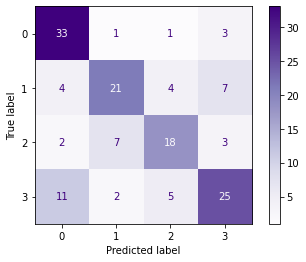

In [40]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_fit, y_fit)
model_predicted = knn.predict(X_eval)
multi_svm_confusion = confusion_matrix(y_true=y_eval, y_pred=model_predicted)
multi_confusion_matrix = ConfusionMatrixDisplay(multi_svm_confusion)
multi_confusion_matrix.plot(cmap=plt.cm.Purples,)
plt.xticks()
plt.show()